# 개요


- keras를 이용하여 CNN을 구현한다.
- mnist 데이터 사용
- 모델을 학습 => 덤프 => site 구축(Flask) => 이미지를 업로드 => 서버에서 예측 => 결과를 돌려준다.
- keras는 딥러닝 엔진을 백엔드로 두고 그 위에서(하이레벨에서) 구동되는 인터페이스다. => 고수준 API를 이용한 딥러닝
  - 텐서플로는 저수준 API를 이용한 딥러닝이라고 이야기할 수 있다.
  - keras는 텐서플로가 아닌 다른 엔진도 쓸 수 있다.
- 난이도는 딥러닝 쪽에서는 가장 쉽다.

# 기본 모듈 가져오기

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

TensorFlow 1.x selected.


'1.15.2'

In [3]:
from tensorflow import keras

In [4]:
# 텐서플로를 백엔드로 사용하는 keras로 CNN 구현하기
keras.__version__

'2.2.4-tf'

In [5]:
# GPU 사용
# 메모리 관련 세팅(차후) -> 디테일 설정
# 보편적으로는 메모리 관련 세팅 없이 사용
with tf.device('/device:GPU:0') :
  print("GPU 사용")

GPU 사용


# 난수 고정

- 목적 : 실험 환경을 일관성 있게 통제하여, 일관성 있는 결과를 내고, 요소별로 어떤 영향을 미치는지 점검할 때 유리

In [6]:
seed_value = 0

In [7]:
# os레벨
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

In [8]:
# 파이썬 기본 모듈 레벨
import random
random.seed(seed_value)

In [9]:
# numpy 레벨
import numpy as np
np.random.seed(seed_value)

In [10]:
# 텐서플로 레벨
tf.set_random_seed(seed_value)

In [11]:
# 케라스 레벨
from tensorflow.keras import backend
session_config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess           = tf.Session(graph=tf.get_default_graph(), config=session_config)
backend.set_session(sess)

# mnist 데이터 준비

In [35]:
from tensorflow.keras.datasets import mnist

In [13]:
# 데이터 로드
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [15]:
type(X_train), type(y_train), type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [16]:
# 데이터 형식 확인
# 케라스가 베이스로 두고 있는, 엔진의 데이터 포맷 확인
# 이 형식에 맞춰서 x를 정의
fmt = backend.image_data_format()
fmt

'channels_last'

In [17]:
# 이미지 세로
PIXEL_H   = X_train.shape[1]
# 이미지 가로
PIXEL_W   = X_train.shape[2] 
# 이미지 총 픽셀 수 => 이미지 1개당 총 특성 수
PIXEL     = PIXEL_H * PIXEL_W
LABEL_NUM = len(np.unique(y_train))

PIXEL_H, PIXEL_W, PIXEL, LABEL_NUM

(28, 28, 784, 10)

In [18]:
# 포맷에 따라 신경망의 입력 x의 형태를 맞출 수 있다.
input_channel = 1
if fmt == 'channels_last' :
  X_train     = X_train.reshape(-1, PIXEL_H, PIXEL_W, input_channel)
  X_test      = X_test.reshape(-1, PIXEL_H, PIXEL_W, input_channel)
  input_shape = ( PIXEL_H, PIXEL_W, input_channel )
elif fmt == 'channels_first' :
  X_train     = X_train.reshape(-1, input_channel, PIXEL_H, PIXEL_W)
  X_test      = X_test.reshape(-1, input_channel, PIXEL_H, PIXEL_W)
  input_shape = ( input_channel, PIXEL_H, PIXEL_W )

In [19]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [20]:
# 정규화를 위해서 타입을 정수에서 부동소수로 변경
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train.dtype, X_test.dtype

(dtype('float32'), dtype('float32'))

In [21]:
# 최대값 기준으로 정규화 수행했다.
X_train /= 255
X_test  /= 255

In [22]:
# 정답에 원-핫 인코딩 필요
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

y_train[:2], y_test[:2]

(array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

# 신경망 구성 사전준비
- Sequential 객체 생성

In [23]:
# 모듈 가져오기
from tensorflow.keras import models, layers, backend

In [24]:
# 백엔드 정보(엔진, 이미지 포맷, 입실론값(임계값))
backend.backend(), backend.image_data_format(), backend.epsilon()

('tensorflow', 'channels_last', 1e-07)

In [25]:
# CNN 기준 -> 텐서플로로 앞에서 작성했던 방식을 그대로 차용하겠다.
# 네트워크를 기반으로 하는 모델을 생성하겠다, 인공신경망을 만들겠다 선언
model= models.Sequential()

# 신경망 구성

- add(망 구성)
- 스타일
  - 절차적 코드
  - 객체지향적 코드

In [26]:
# 1. 입력층부터 시작하여 합성곱층 1F 구성
#    W값은 Conv2D 클래스의 기본 설정값으로 사용, b도 기본 설정값으로 사용
model.add(layers.Conv2D(
    filters     = 32,              # 출력 채널 수의 정수값
    kernel_size = (5,5),           # 커널의 크기
    strides     = (1,1),           # 스트라이드의 이동폭
    padding     = 'same',          # 패딩의 타입
    activation  = 'relu',          # 활성화 함수
    input_shape = input_shape      # 입력 데이터 순서
))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [27]:
# 2. 풀링층 1F 구성
model.add(layers.MaxPool2D(
    pool_size = (2,2),      # 커널의 크기
    strides   = None,       # 커널의 크기와 같은 사이즈로 이동한다. 
    padding   = 'same'      # 패딩값, popup 보면 소문자로 값 입력함을 알 수 있음
))

In [28]:
# 3. 합성곱층 2F 구성
# input_shape은 최초 지정값을 따라간다.
model.add(layers.Conv2D(
    filters     = 32*2,            # 출력 채널 수의 정수값
    kernel_size = (5,5),           # 커널의 크기
    padding     = 'same',          # 패딩의 타입
    activation  = 'relu'           # 활성화 함수
))

In [29]:
# 4. 풀링층 2F 구성
model.add(layers.MaxPool2D(
    padding   = 'same'
))

In [30]:
# 5. 전결합층 구성
model.add(layers.Flatten())     # (-1,7,7,64) -> (-1,7*7*64)
model.add(layers.Dense(         # (-1,7*7*64) -> (-1, 1024), 1024는 설정값
    units      = 1024,
    activation = 'relu'
))

In [31]:
# 6. 과적합 방지층 구성
model.add(layers.Dropout(0.5))

In [32]:
# 7. 출력층 구성
model.add(layers.Dense(
    units      = LABEL_NUM, 
    activation = 'softmax'
))

# 손실함수, 최적화, 학습, 예측
- compile(도구 설정)

In [33]:
model.compile( 
    optimizer ='rmsprop',                                 # 최적화도구,손실함수를미세조정하는알고리즘,sgd,adam,rmsprop,..
    loss      = tf.keras.losses.categorical_crossentropy, # 손실함수 알고리즘 
    #loss     = 'categorical_crossentropy',
    metrics   = ['accuracy']
)

# 실제 학습
- fit()
- epoch, 조기학습종료 연결

In [34]:
# 몇 세대 학습할 것이냐
epochs     = 10     # 전체 데이터를 다 학습을 마치는 것이 1세대 => 10회 반복
batch_size = 128    # 1회 학습 시 128개 데이터를 가지고 학습을 수행 => 총 6만개가 끝나면 1 epoch 완료

In [ ]:
aa # 에러 발생 -> 다음 학습으로 가거나 조기학습종료로 갈 것

In [ ]:
# 학습
with tf.device('/device:GPU:0') :
  hist = model.fit(
      x                = X_train,      # 훈련 데이터
      y                = y_train,      # 정답 데이터
      epochs           = epochs,       # 전체 훈련의 세대 수
      batch_size       = batch_size,   # 1세대 내에서 전체 데이터를 미니 배치 학습으로 훈련 시 1회 사용되는 데이터양
      validation_split = 0.2           # 훈련 데이터 중 20%는 검증용 데이터로 사용 -> 실제 훈련은 48000개(48000 vs 12000)
  )

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 86us/sample - loss: 0.1737 - acc: 0.9452 - val_loss: 0.0545 - val_acc: 0.9843
Epoch 2/10
48000/48000 [==============================] - 3s 53us/sample - loss: 0.0462 - acc: 0.9853 - val_loss: 0.0341 - val_acc: 0.9910
Epoch 3/10
48000/48000 [==============================] - 3s 52us/sample - loss: 0.0307 - acc: 0.9906 - val_loss: 0.0353 - val_acc: 0.9908
Epoch 4/10
48000/48000 [==============================] - 3s 52us/sample - loss: 0.0230 - acc: 0.9931 - val_loss: 0.0344 - val_acc: 0.9908
Epoch 5/10
48000/48000 [==============================] - 3s 52us/sample - loss: 0.0179 - acc: 0.9942 - val_loss: 0.0345 - val_acc: 0.9920
Epoch 6/10
48000/48000 [==============================] - 3s 52us/sample - loss: 0.0154 - acc: 0.9954 - val_loss: 0.0367 - val_acc: 0.9911
Epoch 7/10
48000/48000 [==============================] - 3s 53us/sample - loss: 0.0123 - acc: 0.9966 - val_loss: 0.

- 로그값을 확인해보면 값이 어느 순간부터 변동이 거의 없다.
- 조기 학습 종료가 필요할 것 같다는 정황이 보인다.

In [ ]:
# 테스트 데이터로 예측
model.evaluate(X_test, y_test)

# 0.9933 -> 신경망 구성할 때 dropout층을 좀 더 많이 넣어줘야 함

10000/10000 [==============================] - 1s 66us/sample - loss: 0.0331 - acc: 0.9925


[0.03306139323488599, 0.9925]

# 시각화를 통한 평가

In [ ]:
# 시각화로 확인
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 훈련 로그, 손실함수, 정확도, 검증용 데이터_손실함수, 검증용 데이터_정확도
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

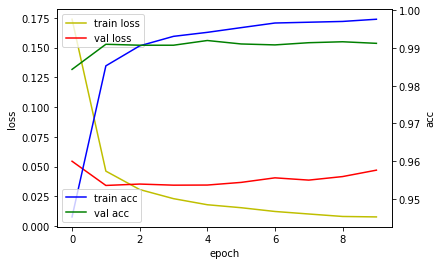

In [ ]:
fig, ax = plt.subplots()

# 데이터를 각각 묶어서 표현 -> ax를 하나 더 생성 -> 범례로 따로 작동
# x축은 공통으로 사용, y축은 왼쪽/오른쪽 각각 사용
acc_ax = ax.twinx()

# 손실
ax.plot(hist.history['loss'],     'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')

# 정확도
acc_ax.plot(hist.history['acc'],     'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

# 레이블
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')

# 범례 위치 지정
ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6세대 정도 도달하면 손실/정확도가 어느 정도 수렴하고 있다(변동폭이 거의 없다)는 것을 알 수 있다.
# 이런 경우 10세대까지 학습하는 행위가 무의미하다. -> 조기 학습 종료를 항상 배치해서 자원이나 시간을 절약할 수 있다.

# 학습 보정
- 조기 학습 종료(earlystopping) 등

In [ ]:
# 개선 => 조기학습 종료
from keras.callbacks import EarlyStopping

with tf.device('/device:GPU:0') :
  early_stop = EarlyStopping()
  hist       = model.fit(
      x                = X_train,
      y                = y_train,
      epochs           = epochs,
      batch_size       = batch_size,
      validation_split = 0.2,
      # 조기 학습 종료 객체를 콜백으로 등록한다.
      callbacks        = [early_stop]
    )
  
# 실제 구동 결과 10세대까지 진행하지 않고, 3세대 정도에서 수렴했다. (loss: 0.0306 - acc: 0.9906 - val_loss: 0.0348 - val_acc: 0.9911)
# 2차 구동 때는 5세대에서 수렴(loss: 0.0174 - acc: 0.9942 - val_loss: 0.0349 - val_acc: 0.9911)

Using TensorFlow backend.


Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 85us/sample - loss: 0.1736 - acc: 0.9456 - val_loss: 0.0516 - val_acc: 0.9849
Epoch 2/10
48000/48000 [==============================] - 2s 52us/sample - loss: 0.0460 - acc: 0.9857 - val_loss: 0.0359 - val_acc: 0.9901
Epoch 3/10
48000/48000 [==============================] - 2s 52us/sample - loss: 0.0309 - acc: 0.9904 - val_loss: 0.0348 - val_acc: 0.9902
Epoch 4/10
48000/48000 [==============================] - 2s 52us/sample - loss: 0.0233 - acc: 0.9931 - val_loss: 0.0339 - val_acc: 0.9917
Epoch 5/10
48000/48000 [==============================] - 2s 52us/sample - loss: 0.0174 - acc: 0.9942 - val_loss: 0.0349 - val_acc: 0.9911


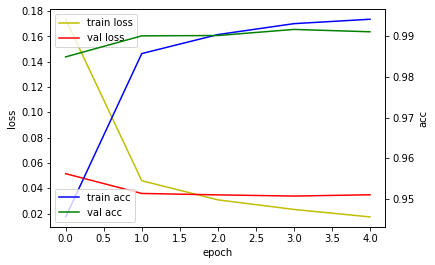

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
acc_ax = ax.twinx()
ax.plot(hist.history['loss'],     'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['acc'],     'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
acc_ax.set_ylabel('acc')
ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

# 시스템 통합을 위한 덤프 작업

## 모델 덤프

In [ ]:
model.save('mnist.h5')
# 이 모델 파일에는 신경망과 그 안에서 설정된 W, b의 조절값이 들어있다.
# 만약에 이미 잘 학습된 모델을 가져다 사용한다 => 전이학습
# 전이학습에서, W, b를 초기화를 하고, 내가 가진 새로운 데이터를 주입해서 학습을 시킨다. + 신경망 추가/변경 가능
# 이미 잘 만들어진 모델을 사용함으로써, 초기 진입에 대한 시간 절약 가능, 성능에 대한 보장을 받을 수 있음

<p align="center"><img src="https://drive.google.com/uc?id=12X0IzKlOIewN2GpxW9blF2KIgeJHetG7" width="30%">

## 모델 아키텍쳐 확인

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

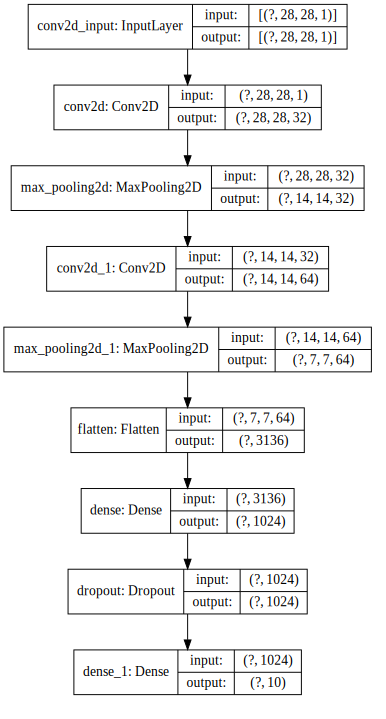

In [ ]:
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

## 모델 검증, 사용

- 모델 로드
- 이미지를 입력
- 예측
- 결과 출력
- 웹 서비스에서 사용할 수 있게 모듈화

In [ ]:
from tensorflow.keras.utils import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import numpy as np
from numpy import argmax

In [ ]:
# 모델 로드
from tensorflow.keras.models import load_model

In [ ]:
loaded_model = load_model('mnist.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# 데이터 준비
# 만약 사이트에서 사용한다면, 이미지 업로드 -> 이미지 읽기 -> 예측에 사용할 수 있는 형태로 가공
# 이미지 1장일 때, (1, 28, 28, 1) 형태로 만들어야 예측이 가능하다
X_test.shape

(10000, 28, 28, 1)

In [ ]:
src = X_test[:1]
src.shape

(1, 28, 28, 1)

In [ ]:
# 예측
src = X_test[:10]
src.shape

(10, 28, 28, 1)

In [ ]:
y = loaded_model.predict_classes(src)
y

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [ ]:
# 실제 정답
# 정답표 : 0, 1, 2, 3, ..., 9 => 인덱스가 동일해서 별도로 인덱스를 가지고 값을 추출하는 과정을 생략
for y_ in y_test[:10] :
  print(argmax(y_), end=" ")

7 2 1 0 4 1 4 9 5 9 

In [ ]:
# argmax를 적용하지 않고, 개별 class들의 확률을 표현해서 출력
y = loaded_model.predict(src)
y

array([[1.19748266e-15, 6.68079958e-13, 6.12528149e-13, 2.50527862e-11,
        6.86427242e-16, 6.50109773e-15, 1.08514387e-19, 1.00000000e+00,
        5.12242963e-15, 2.88428951e-11],
       [7.12657711e-11, 1.82999393e-08, 1.00000000e+00, 2.75595900e-11,
        1.02930772e-12, 2.44281076e-17, 5.88902468e-11, 2.23579618e-12,
        1.57398643e-11, 1.18974790e-13],
       [2.49501780e-10, 9.99998212e-01, 1.81031246e-09, 7.49764972e-11,
        3.18338181e-07, 9.05183928e-09, 9.67548619e-09, 1.32290972e-06,
        7.13186452e-08, 1.77597859e-09],
       [9.99998569e-01, 7.84465340e-11, 5.95940968e-08, 1.39053513e-09,
        1.16573515e-10, 2.55850297e-09, 1.26671694e-06, 3.39991111e-08,
        8.20391932e-09, 2.73822831e-08],
       [2.97912308e-15, 8.91388092e-13, 8.40523940e-14, 5.53893605e-17,
        1.00000000e+00, 6.93841414e-14, 1.25039898e-12, 5.17181827e-12,
        3.26194773e-13, 7.52045370e-10],
       [3.45813350e-10, 9.99992371e-01, 5.43757839e-09, 3.70616524e-11,
   

# mnist 데이터 1개 저장

In [43]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_test.shape

(10000, 28, 28)

In [44]:
# 이미지 1개
X_test[:1].shape

(1, 28, 28)

In [45]:
# (1, 28, 28) -> (1, 28*28)
tmp = X_test[:1].reshape(28*28)
tmp.shape

(784,)

In [46]:
tmp

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        77, 254, 107,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [47]:
# 현재 데이터는 정수 -> 문자열로 변경
strPixelData = list(map(lambda x : str(x), tmp))
strPixelData[:10]

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

In [41]:
# 리스트를 한 개의 문자열로 만들고, 그 사이에는 빈칸으로 채운다. -> join

In [48]:
# 파일 저장
# P2 : 매직코드, 28 : 세로/가로 크기, 255 : 컬러의 최대값, \n : 줄바꿈
with open('test3.pgm', 'w', encoding='utf8') as f :
  f.write('P2 28 28 255\n' + ' '.join(strPixelData))
# 검증 사이트 -> 저장된 파일을 다운로드해서 해당 사이트에 드래그하여 확인
# http://paulcuth.me.uk/netpbm-viewer/

# pgm을 받아서, (1, 28, 28, 1)로(배열, 정수) 만드는 인코딩 과정이 필요

# 서비스

- 서비스 환경 : Flask
- 1페이지
  - jQuery를 이용하여 js로 파일 업로드
  - 서버에서 파일을 읽고, 예측용 데이터로 변환 -> 예측 수행 -> 결과를 돌려준다.
  - 화면은 해당 결과를 출력하여 완료

In [ ]:
# 예측값을 기준으로 정답을 획득

In [ ]:
# 모델 덤프 -> 서비스로 이동

## VS Code - Flask

<img src="https://drive.google.com/uc?id=1J2_vi32_n9Z9J_1D-jMpSarLkNtTAsLH" width="30%">

- ./model/__init__.py

  ```
  import numpy as np
  from tensorflow.keras.models import load_model

  def predictPgmFile( f ) :
      # 파일의 내용을 읽는다
      # with open('./dl_cnn_svr/static/' + f.filename) as f :
      # 단, 바이너리 파일인 경우는 검토가 필요하고, 파일이 너무 크면 저장한 뒤 조금씩 읽어서 처리
      src = f.read().decode("utf-8")
      # print(src)
      # 상위 내용 중 매직코드, 높이, 너비, 컬러 수를 제외(\n를 구분자로 split)
      #  -> 나눠진 내용 중 뒤쪽 데이터(픽셀) 공백으로 스플릿
      tmp = src.split('\n')[-1].split()
      # 스플릿의 결과가 리스트(문자열) -> 정수형으로 변환
      tmp = list(map(int, tmp))
      # ------------------------------------------------------------------------------------------------
      # 정수형 리스트로 배열 생성
      tmp = np.array(tmp, dtype=np.float32)
      # 255로 정규화 처리
      tmp /= 255
      # 배열을 reshape 수행하여 (1,28,28,1)로 변환
      tmp = tmp.reshape(-1, 28, 28, 1)
      # ------------------------------------------------------------------------------------------------
      # 모델 로드
      # 매번 요청할 때마다 모델을 로드한다.
      # -> 모델 교체가 용이하다. 업그레이드가 용이하다.
      #  -> 모델 교체 시 서버를 셧다운하지 않아도 된다.
      # 단, 모델을 로드할 때 생기는 시간적 손해는 존재
      loaded_model = load_model('./model/mnist.h5')
      # 모델에 데이터를 넣고 예측
      pred = loaded_model.predict_classes(tmp)
      prob = loaded_model.predict(tmp)
      # 확률값 중에서 가장 큰 값의 인덱스를 획득
      max_id = np.argmax(prob[0])
      # prob[0][max_id] : 해당 인덱스를 이용해 확률값 획득
      # 예측 결과를 기반으로 응답
      return {'code' : 1, 'msg' : 'upload complete', 'pred' : int(pred[0]), 'prob' : float(prob[0][max_id])}
  ```



- ./run.py
  ```
  from flask import Flask, render_template, request, jsonify
  from model import predictPgmFile

  app = Flask(__name__)

  @app.route('/', methods=['GET', 'POST'])
  def home() :
      if request.method == 'GET' :
          return render_template('home.html')
      else :
          # 요청 객체에서 파일을 추출
          # print('파일 업로드 1')
          f = request.files['FILE_TAG']
          # print(f)
          # print(f.filename)
          # 파일 저장
          # f.save('./static/' + f.filename)
          # f.save(f.filename)
          # 파일을 모델에서 예측할 수 있게 전달
          res = predictPgmFile(f)
          return jsonify(res)
          # return jsonify({'code' : 1, 'msg' : 'upload complete'})

  if __name__ == '__main__' :
      app.run(debug=True)
  ```

- ./templates/home.html
  ```
  <html>
  <head>
      <script src="http://code.jquery.com/jquery-1.11.1.min.js"></script>
  </head>
  <body>
      <div>
          <fieldset>
              <form id="FILE_FORM" method="post" enctype="multipart/form-data" action="">
                  <input type="file" id="FILE_TAG" name="FILE_TAG">        
                  <a class="ui-shadow ui-btn ui-corner-all" href="javascript:uploadFile();">전송</a>
              </form>
              <sapn>이 이미지는 숫자 <b></b>일 확률이 <i></i>%입니다.</sapn>
          </fieldset>
      </div>
      <script>
          function uploadFile(){
              // form 태그로부터 from 요소 획득
              var form = $('#FILE_FORM')[0];
              // 업로드하는 데이터 형식 => FormData
              var formData = new FormData(form);
              // 업로드하는 파일을 추가
              formData.append("fileObj", $("#FILE_TAG")[0].files[0]);
              // formData라는 객체에 업로드해야하는 파일을 모두 등록
              $.ajax({
                  url         : '',                             // 주소
                  processData : false,                          // 전송 시 데이터 진행 과정
                  contentType : false,                          // 컨텐츠 타입
                  data        : formData,                       // 파라미터
                  type        : 'POST',                         // post 전송, get 방식은 보낼 수 있는 용량이 적어서 무조건 post 방식 사용
                  success     : (result)=>{                     // 업로드 성공 시 응답을 받는 콜백함수
                      console.log("업로드 성공!!", result.pred);
                      $('b').empty()                            // 내부를 지우고
                      $('b').html(result.pred)
                      $('i').empty()
                      $('i').html(result.prob*100)
                  },
                  error       : (err)=>{
                      console.log('오류', err)
                  }
              });
          }
      </script>
  </body>
  </html>
  ```

- requirement.txt
  ```
  tensorflow==1.15.2
  ```
- 터미널에서 설치
  - pip install -r requirements.txt
  - 위치가 C:\Users\amin\Desktop\py_projects\dl에서 시작해서 cd ./dl_cnn_svr 명령어를 이용해 C:\Users\amin\Desktop\py_projects\dl\dl_cnn_svr로 이동